In [1]:
import os
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import SegformerImageProcessor
from model.SegFormer1 import get_model
from utils import preprocessor
import random

# Fix seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [14]:
# Load Dataset Using preprocessor
train_dataset,valid_dataset,test_dataset = preprocessor.get_datasets(task=1)

Number of training examples: 300
Number of validation examples: 60
Number of test examples: 240


In [13]:
# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=12)

In [4]:
# Load SegFormer using imported model loader
model = get_model()

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head

In [5]:
# mIOU evaluation
metric = evaluate.load("mean_iou")

# set optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10 # Epochs
best_mean_iou = 0
for epoch in range(num_epochs):  
    model.train()
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
            logits_tensor = nn.functional.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False,
            ).argmax(dim=1)
          
            metric.add_batch(predictions=logits_tensor.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # Print loss and metrics every epochs
    metrics = metric.compute(num_labels=2,ignore_index=255)
    print("Loss:", loss.item())
    print("Mean_iou:", metrics["mean_iou"])
    print("Mean accuracy:", metrics["mean_accuracy"])
                
    # Evaluate on validation set
    model.eval()
    val_metric = evaluate.load("mean_iou")
    for idx, batch in enumerate(tqdm(valid_dataloader)):
        with torch.no_grad():
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            logits_tensor = nn.functional.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False,
            ).argmax(dim=1)

            val_metric.add_batch(predictions=logits_tensor.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    val_metrics = val_metric.compute(num_labels=2,ignore_index=255)
    print("Validation Mean_iou:", val_metrics["mean_iou"])
    print("Validation Mean accuracy:", val_metrics["mean_accuracy"])
    if val_metrics["mean_iou"] > best_mean_iou:
        best_mean_iou = val_metrics["mean_iou"]
        torch.save(model.state_dict(), "./output/task1_best_model.pth")
    print("--------------------")

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.2849976718425751
Mean_iou: 0.7634260977927447
Mean accuracy: 0.9049441623410687


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.8451522586938637
Validation Mean accuracy: 0.9508514452059418
--------------------
Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.20378626883029938
Mean_iou: 0.8661447264326236
Mean accuracy: 0.9484860646405942


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.878503164196339
Validation Mean accuracy: 0.959136403892773
--------------------
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.15279196202754974
Mean_iou: 0.8872237119868216
Mean accuracy: 0.9555784202893087


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9120035321296027
Validation Mean accuracy: 0.9631782796935683
--------------------
Epoch: 3


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.12974421679973602
Mean_iou: 0.910952682815549
Mean accuracy: 0.9614786590881792


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.921968049032843
Validation Mean accuracy: 0.9692860663021388
--------------------
Epoch: 4


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.11865770071744919
Mean_iou: 0.9245422554823486
Mean accuracy: 0.9657353238909636


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9331211100571662
Validation Mean accuracy: 0.9666359568414955
--------------------
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.12122070789337158
Mean_iou: 0.9312896909577977
Mean accuracy: 0.9671261727445537


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9360688648494294
Validation Mean accuracy: 0.9699495526723472
--------------------
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.10339900106191635
Mean_iou: 0.9391720137082349
Mean accuracy: 0.9697231413437091


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9385168910746473
Validation Mean accuracy: 0.972547391423785
--------------------
Epoch: 7


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.1326473355293274
Mean_iou: 0.9449667507404438
Mean accuracy: 0.9725458742274953


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9417577863765887
Validation Mean accuracy: 0.9699382489975963
--------------------
Epoch: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.08089213818311691
Mean_iou: 0.9452038002905496
Mean accuracy: 0.9723537435387257


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9437640953494593
Validation Mean accuracy: 0.9736996065583108
--------------------
Epoch: 9


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 0.06957941502332687
Mean_iou: 0.9469570957124078
Mean accuracy: 0.9729121928469606


  0%|          | 0/5 [00:00<?, ?it/s]

Validation Mean_iou: 0.9442180015765222
Validation Mean accuracy: 0.9740844927514496
--------------------


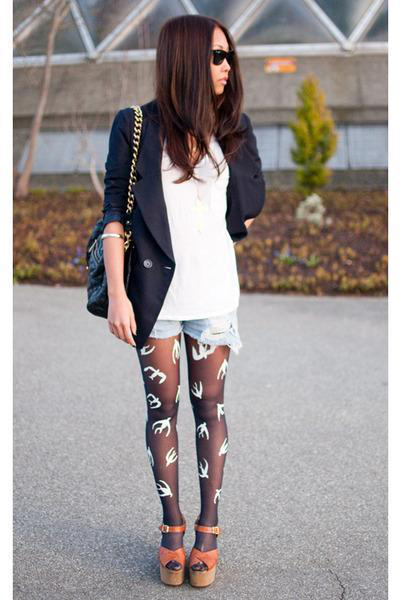

In [6]:
# A Testing Example to see if model is working

image = Image.open('data/images/0001.jpg')
image

In [7]:
image_processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [8]:
outputs = model(pixel_values=pixel_values)

In [9]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [10]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

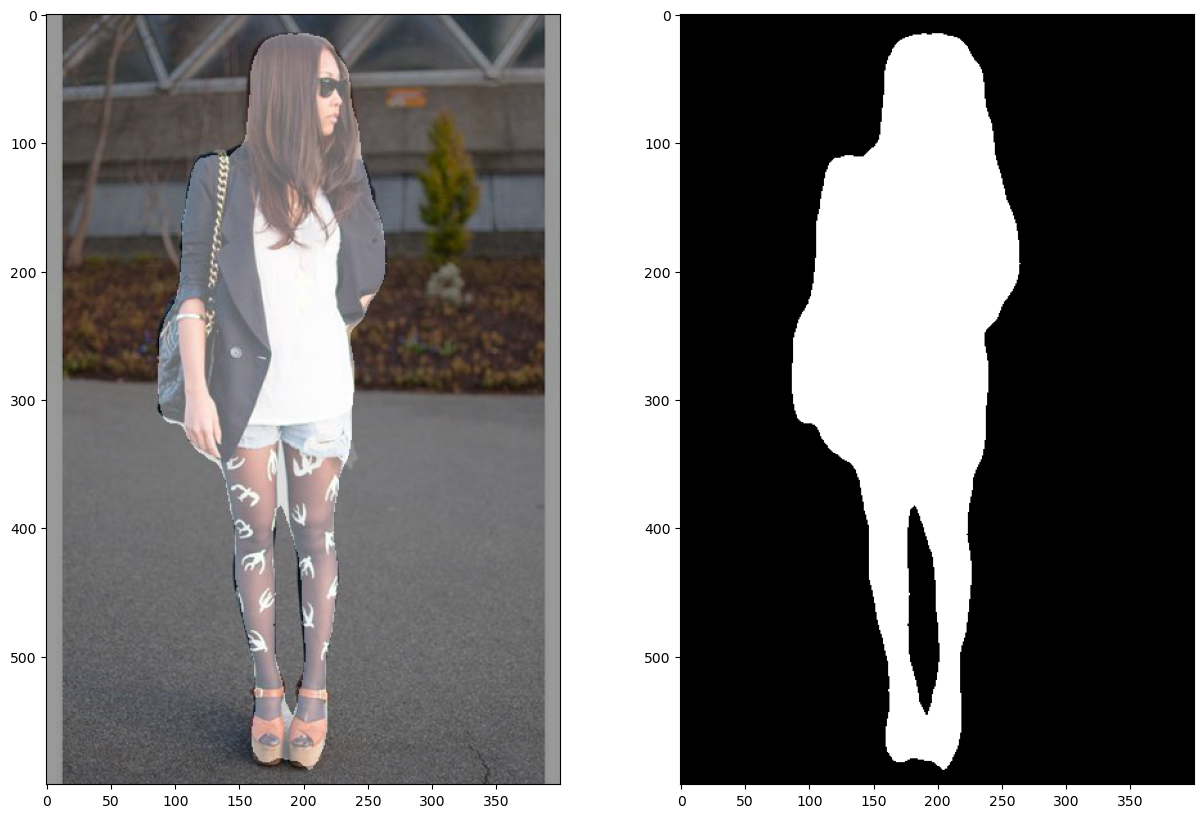

In [11]:
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array([[0,0,0],[255,255,255]])
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to RGB

image = np.array(image) * 0.6 + color_seg * 0.4  # plot the image with the segmentation map
image = image.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(color_seg)
plt.show()